In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split
import numpy as np
import emcee
from scipy.stats import poisson
from scipy.optimize import minimize
from tqdm import tqdm
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import corner

# Simulation-based (likelihood-free) inference

# Simple bump-on-power-law example

Text(0, 0.5, 'Counts')

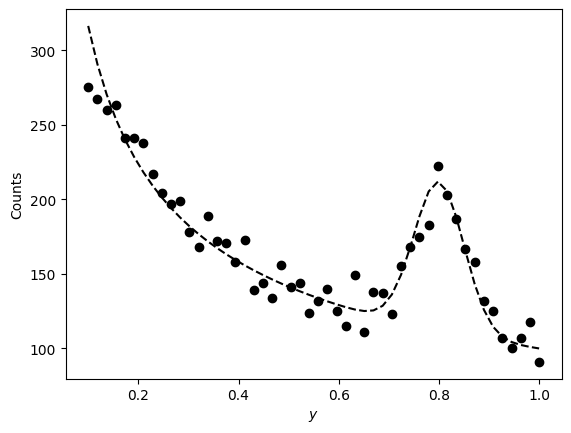

In [42]:
def bump_forward_model(y, amp_s, mu_s, std_s, amp_b, exp_b):
    """ Forward model for a Gaussian bump (amp_s, mu_s, std_s) on top of a power-law background (amp_b, exp_b).
    """
    x_b = amp_b * (y ** exp_b)  # Power-law background
    x_s = amp_s * np.exp(-((y - mu_s) ** 2) / (2 * std_s ** 2))  # Gaussian signal

    x = x_b + x_s  # Total mean signal

    return x

y = np.linspace(0.1, 1, 50)  # Dependent variable

# Mean expected counts
x_mu = bump_forward_model(y, 
                    amp_s=100, mu_s=0.8, std_s=0.05,  # Signal params
                    amp_b=100, exp_b=-0.5)  # Background params

# Realized counts
x = np.random.poisson(x_mu)

# Plot
plt.plot(y, x_mu, color='k', ls='--')
plt.scatter(y, x, color='k')

plt.xlabel("$y$")
plt.ylabel("Counts")

## The explicit likelihood

In [43]:
def log_like(theta, y, x):
    amp_s, mu_s, std_s, amp_b, exp_b = theta
    mu = bump_forward_model(y, amp_s, mu_s, std_s, amp_b, exp_b)
    return poisson.logpmf(x, mu).sum()

log_like([100, 0.8, 0.05, 100, -0.5], y, x)

-194.37849408468986

In [44]:
def log_like_sig(params, y, x):
    amp_s, mu_s = params
    std_s, amp_b, exp_b = 0.05, 100, -0.5
    mu = bump_forward_model(y, amp_s, mu_s, std_s, amp_b, exp_b)
    return poisson.logpmf(x, mu).sum()

In [45]:

opt = minimize(lambda thetas: -log_like_sig(thetas, y, x), x0=[1, 1])
opt.x

array([97.8356246 ,  0.80615504])

In [46]:
def log_prior(thetas):
    amp_s, mu_s = thetas
    if 0 < amp_s < 200 and 0 < mu_s < 2:
        return 0
    else:
        return -np.inf
    
def log_post(thetas, y, x):
    lp = log_prior(thetas)
    if not np.isfinite(lp):
        return -np.inf
    else:
        return lp + log_like_sig(thetas, y, x)
    
ndim, nwalkers = 2, 32
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_post, args=(y, x))

pos = opt.x + 1e-2 * np.random.randn(nwalkers, ndim)
sampler.run_mcmc(pos, 5000, progress=True);

100%|██████████| 5000/5000 [00:05<00:00, 908.87it/s]


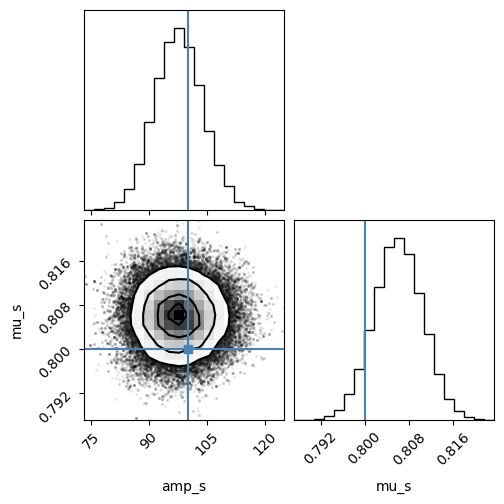

In [47]:
flat_samples = sampler.get_chain(discard=1000, flat=True)
corner.corner(flat_samples, labels=["amp_s", "mu_s"], truths=[100, 0.8]);

## The implicit likelihood

In [62]:
def bump_simulator(thetas, y):
    amp_s, mu_s = thetas
    std_s, amp_b, exp_b = 0.05, 100, -0.5
    x_mu = bump_forward_model(y, amp_s, mu_s, std_s, amp_b, exp_b)
    x = np.random.poisson(x_mu)
    return x

bump_simulator([100, 0.8], y)

array([328, 272, 281, 299, 259, 233, 218, 198, 194, 164, 173, 196, 197,
       176, 160, 162, 150, 155, 140, 159, 149, 122, 162, 157, 127, 138,
       148, 129, 138, 145, 109, 111, 116, 156, 138, 172, 191, 224, 207,
       211, 193, 151, 150, 139, 116,  95,  98,  91, 102, 118])

In [65]:
x_fwd = bump_simulator([100, 0.8], y)
crit = np.sum(np.abs(x - x_fwd) ** 2) / len(x)
crit

382.32

### Approximate Bayesian Computation (ABC)

In [70]:
def abc(y, x, crit_thresh=500, n_samples=1000):
    samples = []
    total_attempts = 0
    progress_bar = tqdm(total=n_samples, desc="Accepted Samples", unit="samples")

    while len(samples) < n_samples:
        params = np.random.uniform(low=[0, 0], high=[200, 1])
        x_fwd = bump_simulator(params, y)  # Assuming bump_simulator is the function that generates bump signals
        crit = np.sum(np.abs(x - x_fwd) ** 2) / len(x)
        total_attempts += 1
        if crit < crit_thresh:
            samples.append(params)
            progress_bar.update(1)
            acceptance_ratio = len(samples) / total_attempts
            progress_bar.set_postfix(acceptance_ratio=f"{acceptance_ratio:.3f}")

    progress_bar.close()
    return np.array(samples)

n_samples = 20_000
post_samples = abc(y, x, crit_thresh=500, n_samples=n_samples)

Accepted Samples: 100%|██████████| 20000/20000 [00:39<00:00, 503.23samples/s, acceptance_ratio=0.025]


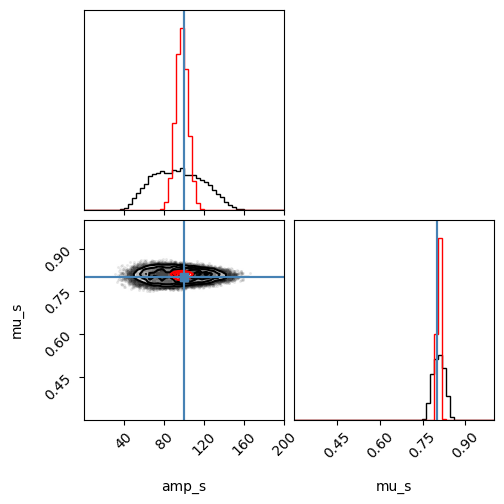

In [80]:
fig = corner.corner(post_samples, labels=["amp_s", "mu_s"], truths=[100, 0.8], range=[(0, 200), (0.3, 1)], bins=50);
corner.corner(flat_samples, labels=["amp_s", "mu_s"], truths=[100, 0.8], fig=fig, color="red", weights=np.ones(len(flat_samples)) * n_samples / len(flat_samples), range=[(0, 200), (0.3, 1)], bins=50);

### Neural likelihood-ratio estimation (NRE)

In [81]:
n_train = 50_000

theta_samples = np.random.uniform(low=[0, 0], high=[200, 1], size=(n_train, 2))
x_samples = np.array([bump_simulator(theta, y) for theta in tqdm(theta_samples)])

# Convert to torch tensors
theta_samples = torch.tensor(theta_samples, dtype=torch.float32)
x_samples = torch.tensor(x_samples, dtype=torch.float32)

# Normalize the data
x_mean = x_samples.mean(dim=0)
x_std = x_samples.std(dim=0)
x_samples = (x_samples - x_mean) / x_std

theta_mean = theta_samples.mean(dim=0)
theta_std = theta_samples.std(dim=0)
theta_samples = (theta_samples - theta_mean) / theta_std

def build_mlp(input_dim, hidden_dim, output_dim, layers, activation=nn.GELU()):
    """Create a MLP from the configurations"""
    seq = [nn.Linear(input_dim, hidden_dim), activation]
    for _ in range(layers):
        seq += [nn.Linear(hidden_dim, hidden_dim), activation]
    seq += [nn.Linear(hidden_dim, output_dim)]
    return nn.Sequential(*seq)

100%|██████████| 50000/50000 [00:00<00:00, 65821.17it/s]


In [88]:
class NeuralRatioEstimator(pl.LightningModule):
    def __init__(self, x_dim, theta_dim):
        super().__init__()
        self.classifier = build_mlp(input_dim=x_dim + theta_dim, hidden_dim=128, output_dim=1, layers=4)

    def forward(self, x):
        return self.classifier(x)
    
    def loss(self, x, theta):

        # Repeat x in groups of 2 along batch axis
        x = x.repeat_interleave(2, dim=0)

        # Get a shuffled version of theta
        theta_shuffled = theta[torch.randperm(theta.shape[0])]

        # Interleave theta and shuffled theta
        theta = torch.stack([theta, theta_shuffled], dim=1).reshape(-1, theta.shape[1])

        # Get labels; ones for pairs from joint, zeros for pairs from marginals
        labels = torch.ones(x.shape[0], device=x.device) 
        labels[1::2] = 0.0

        # Pass through parameterized classifier to get logits
        logits = self(torch.cat([x, theta], dim=1))
        probs = torch.sigmoid(logits).squeeze()

        return nn.BCELoss(reduction='none')(probs, labels)


    def training_step(self, batch, batch_idx):
        x, theta = batch
        loss = self.loss(x, theta).mean()
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, theta = batch
        loss = self.loss(x, theta).mean()
        self.log("val_loss", loss)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=3e-4)

In [89]:
nre = NeuralRatioEstimator(x_dim=50, theta_dim=2)
nre.loss(x_samples[:64], theta_samples[:64])

tensor([0.7241, 0.6635, 0.7222, 0.6650, 0.7229, 0.6645, 0.7225, 0.6646, 0.7224,
        0.6648, 0.7238, 0.6635, 0.7241, 0.6632, 0.7228, 0.6644, 0.7241, 0.6632,
        0.7243, 0.6630, 0.7226, 0.6648, 0.7231, 0.6637, 0.7233, 0.6644, 0.7236,
        0.6637, 0.7228, 0.6645, 0.7254, 0.6619, 0.7234, 0.6643, 0.7228, 0.6647,
        0.7234, 0.6637, 0.7226, 0.6644, 0.7227, 0.6647, 0.7238, 0.6631, 0.7228,
        0.6642, 0.7239, 0.6635, 0.7230, 0.6639, 0.7240, 0.6634, 0.7229, 0.6642,
        0.7227, 0.6639, 0.7226, 0.6649, 0.7229, 0.6640, 0.7229, 0.6640, 0.7232,
        0.6638, 0.7231, 0.6637, 0.7221, 0.6649, 0.7227, 0.6645, 0.7239, 0.6635,
        0.7234, 0.6638, 0.7230, 0.6642, 0.7232, 0.6642, 0.7238, 0.6633, 0.7226,
        0.6645, 0.7224, 0.6652, 0.7240, 0.6630, 0.7217, 0.6655, 0.7231, 0.6644,
        0.7229, 0.6643, 0.7233, 0.6639, 0.7229, 0.6643, 0.7239, 0.6629, 0.7228,
        0.6642, 0.7228, 0.6648, 0.7243, 0.6629, 0.7236, 0.6637, 0.7231, 0.6645,
        0.7233, 0.6639, 0.7237, 0.6639, 

In [90]:

val_fraction = 0.1
batch_size = 128
n_samples_val = int(val_fraction * len(x_samples))

dataset = TensorDataset(x_samples, theta_samples)

dataset_train, dataset_val = random_split(dataset, [len(x_samples) - n_samples_val, n_samples_val])
train_loader = DataLoader(dataset_train, batch_size=batch_size, num_workers=8, pin_memory=True, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=batch_size, num_workers=8, pin_memory=True, shuffle=False)


In [91]:
trainer = pl.Trainer(max_epochs=20)
trainer.fit(model=nre, train_dataloaders=train_loader, val_dataloaders=val_loader);

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/homebrew/Caskroom/miniforge/base/envs/torch-mps/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:200: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(

  | Name       | Type       | Params
------------------------------------------
0 | classifier | Sequential | 73.0 K
------------------------------------------
73.0 K    Trainable params
0         Non-trainable params
73.0 K    Total params
0.292     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


In [95]:
def log_like(theta, x):
        
    x = torch.Tensor(x)
    theta = torch.Tensor(theta)

    # Normalize
    x = (x - x_mean) / x_std
    theta = (theta - theta_mean) / theta_std

    x = torch.atleast_1d(x)
    theta = torch.atleast_1d(theta)

    return nre.classifier(torch.cat([x, theta], dim=-1)).squeeze()

theta_test = np.array([90, 0.8])
x_test = bump_simulator(theta_test, y)

log_like(theta_test, x_test)

tensor(4.2368, grad_fn=<SqueezeBackward0>)

In [96]:
def log_post(theta, x):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    else:
        return lp + log_like(theta, x)

In [97]:
ndim, nwalkers = 2, 32
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_post, args=(x_test,))

pos = opt.x + 1e-3 * np.random.randn(nwalkers, ndim)
sampler.run_mcmc(pos, 5000, progress=True);

100%|██████████| 5000/5000 [00:21<00:00, 228.55it/s]


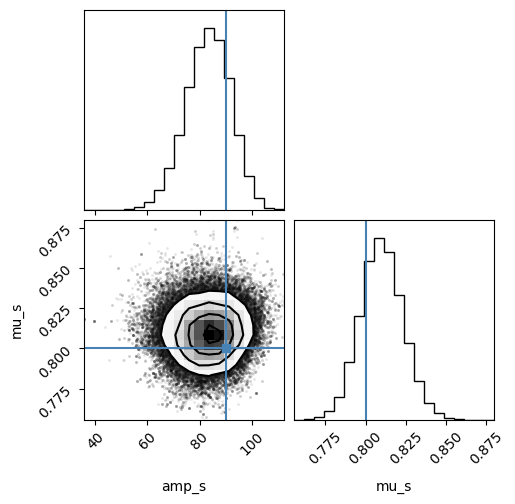

In [98]:
flat_samples = sampler.get_chain(discard=1000, flat=True)
corner.corner(flat_samples, labels=["amp_s", "mu_s"], truths=[90, 0.8]);

### Neural posterior estimation (NPE)

In [99]:
from nflows.flows.base import Flow
from nflows.distributions.normal import StandardNormal
from nflows.transforms.base import CompositeTransform
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform
from nflows.transforms.permutations import ReversePermutation

In [111]:
def get_flow(d_in=2, d_hidden=32, d_context=16, n_layers=4):
    """ Instantiate a simple (Masked Autoregressive) normalizing flow.
    """

    base_dist = StandardNormal(shape=[d_in])

    transforms = []
    for _ in range(n_layers):
        transforms.append(ReversePermutation(features=d_in))
        transforms.append(MaskedAffineAutoregressiveTransform(features=d_in, hidden_features=d_hidden, context_features=d_context))
    transform = CompositeTransform(transforms)

    flow = Flow(transform, base_dist)
    return flow

flow = get_flow()

samples, log_prob = flow.sample_and_log_prob(num_samples=100, context=torch.randn(2, 16))
print(samples.shape, log_prob.shape)

torch.Size([2, 100, 2]) torch.Size([2, 100])


In [112]:
class NeuralPosteriorEstimator(pl.LightningModule):
    def __init__(self, featurizer, d_context=16):
        super().__init__()
        self.featurizer = featurizer
        self.flow = get_flow(d_in=2, d_hidden=32, d_context=d_context, n_layers=4)

    def forward(self, x):
        return self.featurizer(x)
    
    def loss(self, x, theta):
        context = self(x)
        return -self.flow.log_prob(inputs=theta, context=context)

    def training_step(self, batch, batch_idx):
        x, theta = batch
        loss = self.loss(x, theta).mean()
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, theta = batch
        loss = self.loss(x, theta).mean()
        self.log("val_loss", loss)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=3e-4)

In [107]:
npe = NeuralPosteriorEstimator(featurizer=build_mlp(input_dim=50, hidden_dim=128, output_dim=16, layers=4))
npe.loss(x_samples[:64], theta_samples[:64])

tensor([-2.8646, -3.9532, -2.3793, -3.9598, -0.4721, -3.9193, -4.1648, -4.1079,
        -3.8055, -2.6645, -4.3867, -1.5856, -2.2467, -3.2812,  1.3000, -3.8933,
        -3.1823, -3.8068, -1.7736, -1.4777, -2.7323, -4.0634, -3.0050, -1.7647,
        -3.1175, -4.0481,  0.4045, -3.1993, -4.0204,  0.7904, -3.8784, -0.3863,
        -2.7678, -3.6799, -3.3105, -3.6810, -3.3356, -1.5120, -2.7539, -1.8544,
         0.0617, -2.7909, -3.4942, -3.9010, -2.7403, -3.2410, -3.5365,  2.0684,
        -3.7770, -0.7487, -3.8996, -3.0319, -0.2770, -2.8027, -3.3036, -2.7240,
        -3.9457, -1.1398, -3.5251, -3.6639, -3.6110, -2.6895, -4.3354, -2.9663],
       grad_fn=<NegBackward0>)

In [103]:
trainer = pl.Trainer(max_epochs=20)
trainer.fit(model=npe, train_dataloaders=train_loader, val_dataloaders=val_loader);

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/homebrew/Caskroom/miniforge/base/envs/torch-mps/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:200: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(

  | Name       | Type       | Params
------------------------------------------
0 | featurizer | Sequential | 74.6 K
1 | flow       | Flow       | 24.3 K
------------------------------------------
99.0 K    Trainable params
0         Non-trainable params
99.0 K    Total params
0.396     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


In [108]:
theta_test = np.array([90, 0.8])
x_test = bump_simulator(theta_test, y)

In [109]:
x_test_norm = (torch.Tensor(x_test) - x_mean) / x_std
context = npe.featurizer(x_test_norm).unsqueeze(0)

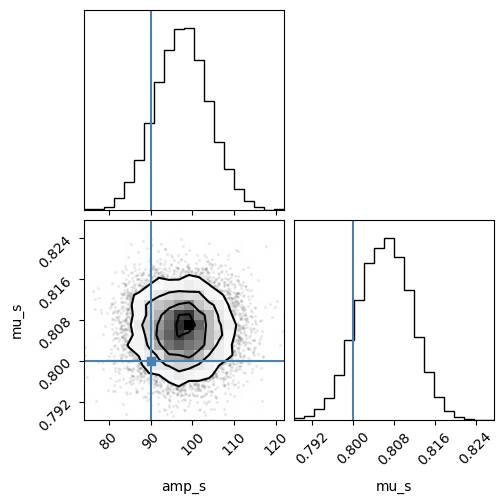

In [110]:
samples_test = npe.flow.sample(num_samples=10000, context=context) * theta_std + theta_mean
samples_test = samples_test.detach().numpy()
corner.corner(samples_test, labels=["amp_s", "mu_s"], truths=[90, 0.8]);

# A more complicated example: distribution of point sources in a 2D image

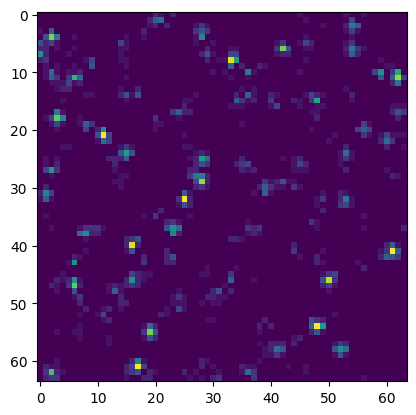

In [114]:
from scipy.stats import binned_statistic_2d
from astropy.convolution import convolve, Gaussian2DKernel

def draw_powerlaw_flux(n_sources, s_min, s_max, exp_b):
    """
    Draw from a powerlaw with slope `exp_b` and min/max mean counts `s_min` and `s_max` . Stolen from:
    https://stackoverflow.com/questions/31114330/python-generating-random-numbers-from-a-power-law-distribution
    """
    u = np.random.uniform(0, 1, size=n_sources)
    s_low_u, s_high_u = s_min ** (exp_b + 1), s_max ** (exp_b + 1)
    return (s_low_u + (s_high_u - s_low_u) * u) ** (1.0 / (exp_b + 1.0))


def simulate_sources(amp_b, exp_b, s_min=0.5, s_max=50.0, box_size=1., resolution=64, sigma_psf=0.01):
    """ Simulate a map of point sources with mean counts drawn from a power law (Pareto) distribution dn/ds = amp_b * s ** (exp_b - 1)
    """
    # Get number of sources by analytically integrating dn/ds and taking Poisson realization
    n_sources = np.random.poisson(-amp_b * (s_min ** (exp_b - 1)) / (exp_b - 1))

    # Draw fluxes from truncated power law amp_b * s ** (exp_b - 1), with s_min and s_max as the bounds
    fluxes = draw_powerlaw_flux(n_sources, s_min, s_max, exp_b)

    positions = np.random.uniform(0., box_size, size=(n_sources, 2))
    bins = np.linspace(0, box_size, resolution + 1)

    pixel_size = box_size / resolution
    kernel = Gaussian2DKernel(x_stddev=1.0 * sigma_psf / pixel_size)

    mu_signal = binned_statistic_2d(x=positions[:, 0], y=positions[:, 1], values=fluxes, statistic='sum', bins=bins).statistic
    counts = np.random.poisson(convolve(mu_signal, kernel))
                
    return fluxes, counts

fluxes, counts = simulate_sources(amp_b=100., exp_b=-1.2)
plt.imshow(counts, cmap='viridis', vmax=20)


## Explicit likelihood

Intractable!

## Implicit inference: Neural posterior estimation

In [115]:
n_train = 10_000

# Sample from prior, then simulate
theta_samples = np.random.uniform(low=[10., -3.], high=[200., -0.99], size=(n_train, 2))
x_samples = np.array([simulate_sources(theta[0], theta[1])[1] for theta in tqdm(theta_samples)])

# Convert to torch tensors
theta_samples = torch.Tensor(theta_samples)
x_samples = torch.Tensor(x_samples)

# Normalize the data
x_mean = x_samples.mean(dim=0)
x_std = x_samples.std(dim=0)
x_samples = (x_samples - x_mean) / x_std

theta_mean = theta_samples.mean(dim=0)
theta_std = theta_samples.std(dim=0)
theta_samples = (theta_samples - theta_mean) / theta_std


100%|██████████| 10000/10000 [00:06<00:00, 1506.55it/s]


In [116]:
val_fraction = 0.1
batch_size = 64
n_samples_val = int(val_fraction * len(x_samples))

dataset = TensorDataset(x_samples, theta_samples)

dataset_train, dataset_val = random_split(dataset, [len(x_samples) - n_samples_val, n_samples_val])
train_loader = DataLoader(dataset_train, batch_size=batch_size, num_workers=8, pin_memory=True, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=batch_size, num_workers=8, pin_memory=True, shuffle=False)


In [117]:
class CNN(nn.Module):
    def __init__(self, output_dim):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(16 * 16 * 16, 64)
        self.fc2 = nn.Linear(64, output_dim)

    def forward(self, x):
        
        x = x.unsqueeze(1)
        
        x = self.pool1(F.leaky_relu(self.conv1(x), negative_slope=0.02))
        x = self.pool2(F.leaky_relu(self.conv2(x), negative_slope=0.02))

        x = x.view(x.size(0), -1)

        x = F.leaky_relu(self.fc1(x), negative_slope=0.01)
        x = self.fc2(x)

        return x

In [118]:
npe = NeuralPosteriorEstimator(featurizer=CNN(output_dim=32), d_context=32)
npe.loss(x_samples[:64], theta_samples[:64])

tensor([4.7706, 4.4101, 4.4756, 4.4511, 4.8587, 4.8454, 5.1136, 4.4731, 4.9039,
        4.4763, 4.4055, 4.4830, 4.4427, 4.4923, 4.4291, 4.7632, 4.5056, 4.4378,
        4.4000, 4.7766, 4.7400, 4.4107, 4.6197, 4.8510, 4.7104, 4.4444, 5.1316,
        5.0471, 4.4271, 4.3994, 4.3990, 4.7458, 4.7437, 4.6407, 4.4993, 4.7269,
        4.4206, 4.4650, 4.8681, 4.5922, 4.7309, 4.5734, 4.7068, 4.8279, 4.4586,
        4.4385, 4.4050, 4.8363, 4.4293, 4.4522, 4.4223, 4.7174, 4.8672, 4.8829,
        4.7048, 4.9177, 4.5971, 4.7082, 4.4523, 4.6936, 4.4349, 4.6949, 4.5052,
        4.8276], grad_fn=<NegBackward0>)

In [119]:
trainer = pl.Trainer(max_epochs=15)
trainer.fit(model=npe, train_dataloaders=train_loader, val_dataloaders=val_loader);

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/homebrew/Caskroom/miniforge/base/envs/torch-mps/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:200: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(

  | Name       | Type | Params
------------------------------------
0 | featurizer | CNN  | 265 K 
1 | flow       | Flow | 30.5 K
------------------------------------
296 K     Trainable params
0         Non-trainable params
296 K     Total params
1.184     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.


In [120]:
npe = npe.eval()

In [121]:
params_test = np.array([15., -1.4])
x_test = simulate_sources(params_test[0], params_test[1])[1]

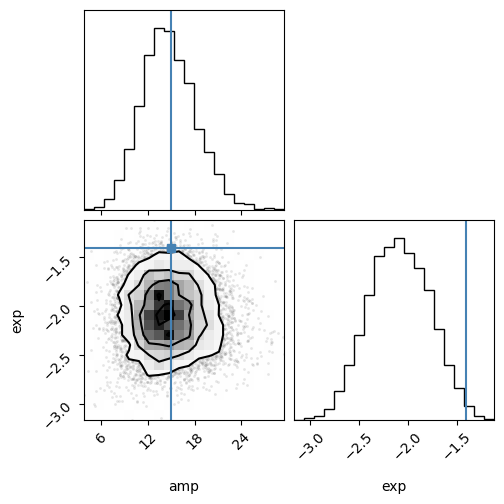

In [122]:
x_test_norm = (torch.Tensor(x_test) - x_mean) / x_std
context = npe.featurizer(x_test_norm.unsqueeze(0))

samples_test = npe.flow.sample(num_samples=10000, context=context) * theta_std + theta_mean
samples_test = samples_test.detach().numpy()

corner.corner(samples_test, labels=["amp", "exp"], truths=params_test);

## Test of statistical coverage

In [123]:
n_test = 200

x_test = torch.Tensor([simulate_sources(params_test[0], params_test[1])[1] for _ in range(n_test)])
x_test_norm = (torch.Tensor(x_test) - x_mean) / x_std

context = npe.featurizer(x_test_norm)

samples_test = npe.flow.sample(num_samples=1000, context=context) * theta_std + theta_mean
samples_test = samples_test.detach().numpy()

/var/folders/nx/bx2847k56j3dddp761x637pc0000gn/T/ipykernel_63554/917087277.py:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:233.)
  x_test = torch.Tensor([simulate_sources(params_test[0], params_test[1])[1] for _ in range(n_test)])


In [124]:
def hpd(samples, credible_mass=0.95):
    """Compute highest posterior density (HPD) of array for given credible mass."""
    sorted_samples = np.sort(samples)
    interval_idx_inc = int(np.floor(credible_mass * sorted_samples.shape[0]))
    n_intervals = sorted_samples.shape[0] - interval_idx_inc
    interval_width = np.zeros(n_intervals)
    for i in range(n_intervals):
        interval_width[i] = sorted_samples[i + interval_idx_inc] - sorted_samples[i]
    hdi_min = sorted_samples[np.argmin(interval_width)]
    hdi_max = sorted_samples[np.argmin(interval_width) + interval_idx_inc]
    return hdi_min, hdi_max

hpd(samples_test[0, :, 0], credible_mass=0.2)

(11.728928, 13.301857)

In [127]:
p_nominals = np.linspace(0.01, 0.99, 20)
contains_true = np.zeros((2, n_test, len(p_nominals)))

for i_param in range(2):
    for i, sample in enumerate(samples_test[:, :, i_param]):
        for j, p_nominal in enumerate(p_nominals):
            hdi_min, hdi_max = hpd(sample, credible_mass=p_nominal)
            if hdi_min < params_test[i_param] < hdi_max:
                contains_true[i_param, i, j] = 1

Text(0.5, 1.0, 'Coverage for exponent')

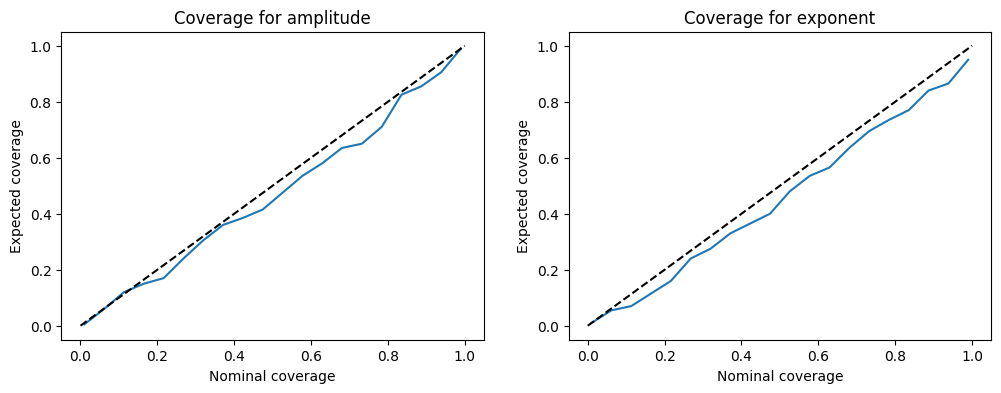

In [132]:
# Make two plots, one for each parameter

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(p_nominals, contains_true[0].sum(0) / n_test)
ax[0].plot([0, 1], [0, 1], color="black", linestyle="--")
ax[0].set_xlabel("Nominal coverage")
ax[0].set_ylabel("Expected coverage")
ax[0].set_title("Coverage for amplitude")



ax[1].plot(p_nominals, contains_true[1].sum(0) / n_test)
ax[1].plot([0, 1], [0, 1], color="black", linestyle="--")
ax[1].set_xlabel("Nominal coverage")
ax[1].set_ylabel("Expected coverage")
ax[1].set_title("Coverage for exponent")